In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [2]:
# Command to use the full widht of the screen
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }/style>"))

In [3]:
def BACN(init_nodes, final_nodes, m_param, l_param=0, CN=False, DIR=False):
    assert init_nodes > 1
    assert init_nodes < final_nodes
    assert init_nodes >= m_param
    assert l_param >= 0
    A = np.zeros((final_nodes, final_nodes)) 
    for i in range(init_nodes):
        for j in range(i+1, init_nodes):
            A[i,j] = 1
            A[j,i] = 1
    for i in range(init_nodes, final_nodes):
        if DIR:
            p_deg_target = np.sum(A[:i,:], axis=1)
            p_deg_target /= np.sum(p_deg_target)
            p_deg_source = np.sum(A[:,:i], axis=0)
            p_deg_source /= np.sum(p_deg_source)
            rand_target = np.random.choice(i, size=m_param, p=p_deg_target, replace=False)
            A[rand_target, i] = 1
            rand_source = np.random.choice(i, size=m_param, p=p_deg_source, replace=False)
            A[i, rand_source] = 1
        else:
            p_deg = np.sum(A, axis=1)[:i]
            p_deg /= np.sum(p_deg)
            rand_node = np.random.choice(i, size=m_param, p=p_deg, replace=False)
            A[i, rand_node] = A[rand_node, i] = 1
        if CN and l_param > 0:
            S = A[:i+1,:i+1]
            cn_mat = S @ S
            S[np.eye(S.shape[0], dtype=bool)] = -1
            missing = np.nonzero(S==0)
            if DIR==False:
                missing = (missing[0][missing[0]<missing[1]], missing[1][missing[0]<missing[1]]) #only upper triangle of adjacency matrix
            if missing[0].size != 0:
                p_cn = cn_mat[missing]
                p_cn /= np.sum(p_cn)
                if np.isnan(p_cn).all():
                    if l_param < missing[0].size:
                        rand_edge = np.random.choice(missing[0].size, size=l_param, replace=False)
                    else:
                        rand_edge = range(missing[0].size)
                else:
                    if l_param > np.count_nonzero(p_cn):
                        rand_edge = np.random.choice(missing[0].size, size=np.count_nonzero(p_cn), p=p_cn, replace=False)
                    else:
                        rand_edge = np.random.choice(missing[0].size, size=l_param, p=p_cn, replace=False)
                a = missing[0][rand_edge]
                b = missing[1][rand_edge]
                if DIR:
                    A[a,b] =  1
                else:
                    A[a,b] = A[b,a] = 1
            S[np.eye(S.shape[0], dtype=bool)] = 0
    return A

In [4]:
testBACN = BACN(2,6,1,2,CN=True,DIR=False)
#testBACN

In [5]:
def cns_number(x, links):
    c_m = x@x
    cn = c_m[links[:,0], links[:,1]]
    return cn

In [6]:
def get_links_to_del(x, fraction=0.1, loops=1, DIR=False):
    if DIR:
        present = np.argwhere(x)
    else:
        present = np.argwhere(np.triu(x, 1) != 0)#== 1)
    num_to_del = int(present.shape[0] * fraction)
    idx_to_del = [np.random.choice(present.shape[0], size=num_to_del, replace=False) for i in range(loops)]
    links_to_del = np.array([present[idx] for idx in idx_to_del])
    return links_to_del

In [7]:
def delete_links(x, links_to_del, DIR=False):
    """Deletes the specified links from an adjacency matrix."""
    z = np.copy(x)
    for link in links_to_del:
        if DIR:
            z[link[0], link[1]] = 0
        else:
            z[link[0], link[1]] = z[link[1], link[0]] = 0
    return z

In [8]:
def evaluate_predictions(true, pred, plot=False):
    precision, recall, _ = precision_recall_curve(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    aupr = auc(recall, precision)
    auroc = auc(fpr, tpr)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(recall, precision, 'go', label='Precision-Recall curve')
        ax.plot(fpr, tpr, '.', label='ROC curve')
        plt.legend()
        plt.show()
    return aupr, auroc

In [9]:
def cross_val_from_notebook(adjacency, links_to_del, loops=1, DIR=False, raw_output=False, verbose=False, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))
    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i+1, loops))
        x_ = delete_links(adjacency, links_to_del[i], DIR)
        missing_initial = np.argwhere(x_ == 0)
        #print("missing_initial", missing_initial)
        missing_final = np.array([list(row) for row in missing_initial if row[0]!=row[1]]) #exclude the diagonal terms
        #print("missing_final", missing_final, missing_final.shape[0])
        if missing_final.shape[0] > 0:
            missing_false = adjacency[missing_final[:,0], missing_final[:,1]]
            scores = cns_number(x_, missing_final)
            if False:#missing_false.any():
                #print("\n")
                print(adjacency)
                print(x_)
                #print("missing_initial:")
                #print(missing_initial)
                print("missing_final:")
                print(missing_final, missing_final.shape[0])
                print("missing_false", missing_false)
                print("scores", scores)
            if raw_output:
                true_list.append(missing_false)
                scores_list.append(scores)
            else:
                results[i] = evaluate_predictions(missing_false, scores, plot=plot)
        else:
            break#print("WTF?")
    if raw_output:
        return np.array(true_list).flatten(), np.asarray(scores_list).flatten()
    else:
        return results

In [10]:
def running_all_parameters(init_nodes, final_nodes, l, fraction=0.1, loops=1, CN=False, DIR=False):
    areas_under_curves = np.zeros((init_nodes+1, 2))
    for m in range(init_nodes+1):
        B = BACN(init_nodes, final_nodes, m, l, CN, DIR)
        links_to_del = get_links_to_del(B, fraction, loops, DIR)
        r1 = cross_val_from_notebook(B, links_to_del, loops, DIR)
        areas_under_curves[m,:] = np.mean(r1, axis=0)
    return areas_under_curves

In [11]:
def ploting_all_parameters(final, lmax, fraction, loops, CN, DIR):
    for i in range(2, final):
        plt.figure(figsize=(20,3))
        for j in range(1, lmax+1):
            a_u_c = running_all_parameters(i, final, j-1, fraction, loops, CN, DIR)
            plt.subplot(1,lmax,j)
            plt.title("I:{}, f:{}\nCN:{}".format(i, final, j))
            plt.xlabel("m")
            plt.ylim([0, 1])
            plt.plot(a_u_c[:,0], 'bx--', label='AUPR')
            plt.plot(a_u_c[:,1], 'ro--', label='AUROC')
            #plt.legend()
        plt.show()

/home/jorge/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/jorge/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/jorge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/jorge/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/jorge/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


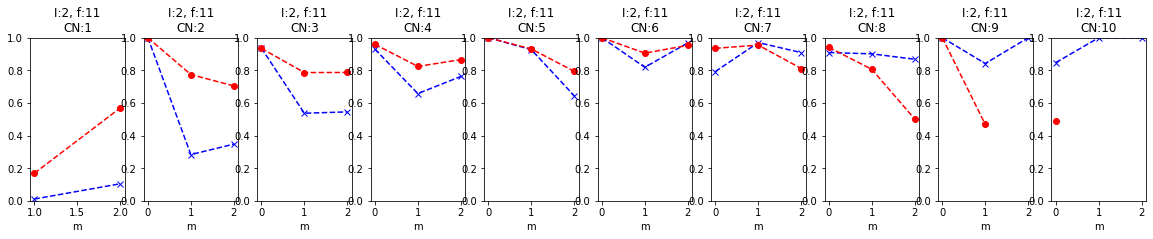

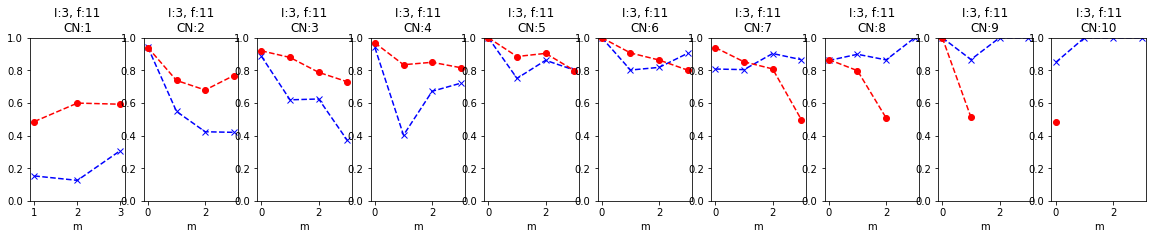

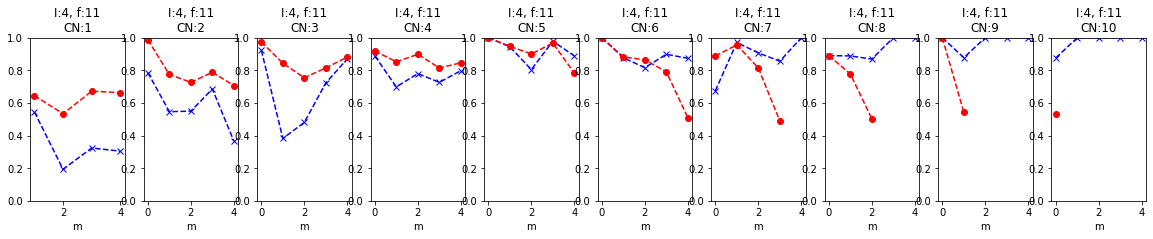

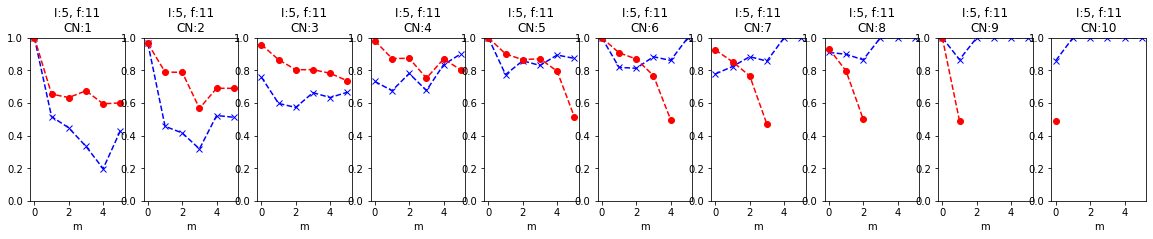

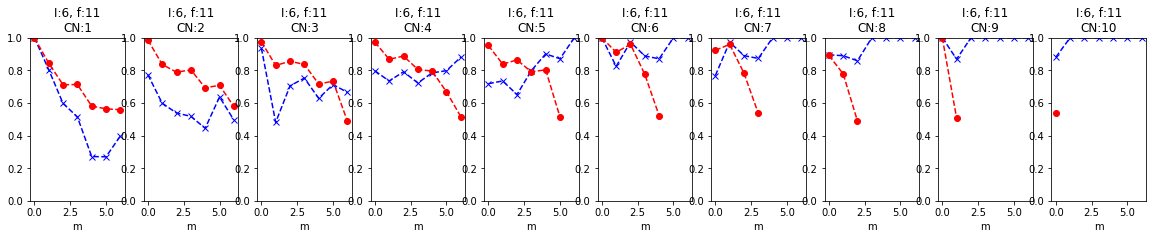

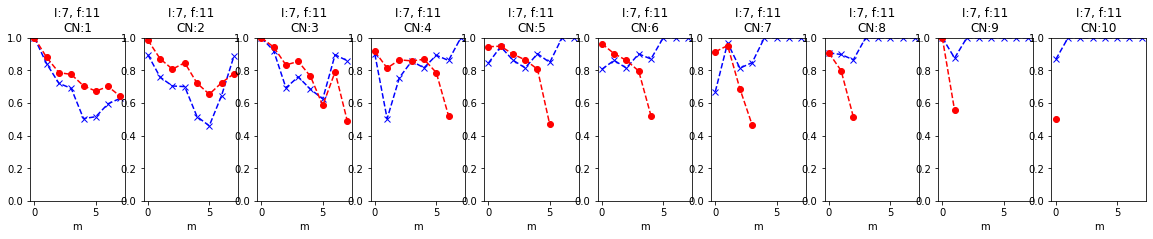

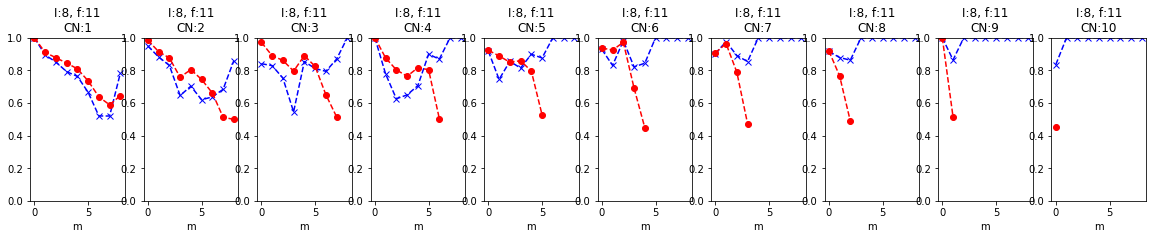

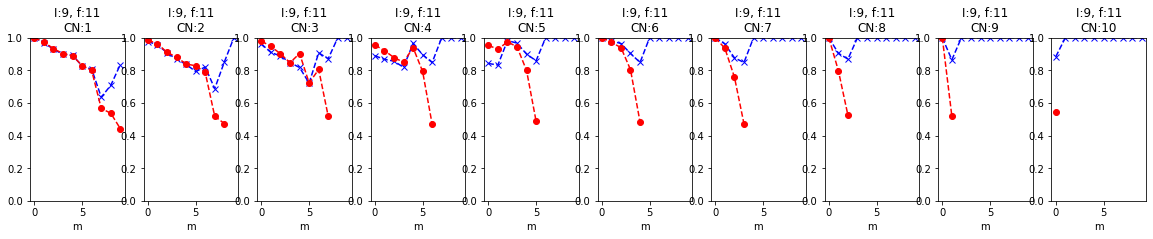

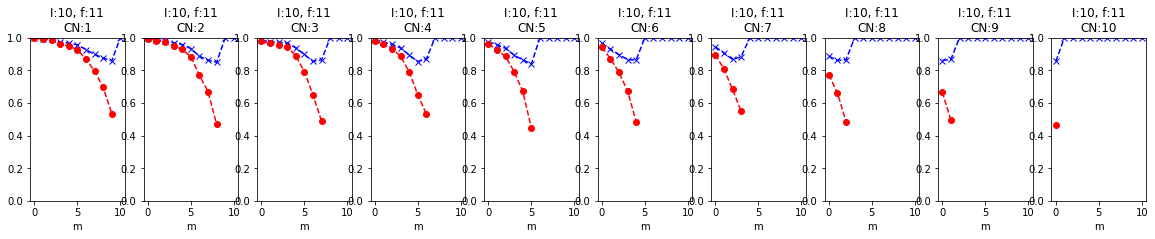

In [12]:
ploting_all_parameters(final=11, lmax=10, fraction=0.1, loops=100, CN=True, DIR=False)